This notebook is used for the creation of model boundary conditions for the North Atlantic model. Just as for the initial condition, the boundary condition vector quantities need to rotated on the curvilinear model domain. 

First, import packages necessary for this notebook:

In [1]:
# import the modules for computation, plotting, and reading files
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import cmocean.cm as cm

# import the necessary modules from eccoseas
from eccoseas.ecco import io
from eccoseas.ecco import grid as eeg
from eccoseas.downscale import hFac
from eccoseas.downscale import horizontal

## Constructing the Boundary Conditions
For this model, we will use a model state from the ECCO Version 5 state estimate. We will prepare the boundary condition fields in 7 steps:
1. download the ECCO model output
2. read the ECCO model grid
3. read in the bathymetry for the regional model as well as its grid
4. prepare the ECCO fields for interpolation
5. interpolate the ECCO fields onto the regional model grid and store each as a binary file
6. plot the interpolated fields to ensure they look as expected
7. create an additional field for 1991

### Step 1: Download the ECCO fields
To begin, I downloaded the model fields generated by the ECCO Version 5 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/nctiles_monthly). In particular, we download the following list of files that contain the fields pertaining to time span of the model (1992 onward):

| Variable | File Name |
| -------- | --------- |
|THETA|THETA/THETA_????.nc|
|SALT|SALT/SALT_????.nc|
|UVEL|UVELMASS/UVELMASS_????.nc|
|VVEL|VVELMASS/VVELMASS_????.nc|
|SIuice|SIuice/SIuice_????.nc|
|SIvice|SIuice/SIvice_????.nc|
|SIheff|SIheff/SIheff_????.nc|
|SIhsnow|SIhsnow/SIhsnow_????.nc|
|SIarea|SIarea/SIarea_????.nc|

There are stored in the following directory:

In [2]:
data_folder = '../../../data/north_atlantic'

### Step 2: Read in the ECCO grid
To read in the ECCO fields, we will rely on the `io` module from the `eccoseas.ecco` package:

In [3]:
ecco_XC_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='XC')
ecco_YC_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='YC')
ecco_AngleCS_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='AngleCS')
ecco_AngleSN_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='AngleSN')
ecco_hFacC_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='hFacC')
ecco_hFacW_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='hFacW')
ecco_hFacS_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='hFacS')
ecco_RF_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='RF')
ecco_DRF_tiles = io.read_ecco_grid_tiles_from_nc(os.path.join(data_folder, 'GRID'), var_name='DRF')

Note that in the previous notebook, we have already identified tiles 3, 7, and 11 as those pertaining to the regional domain.

### Step 3: Read in the Model Grid and Generate a Mask
Here, I will recreate the grid I will use in my model and read in the bathymetry file (see previous notebooks for details):

In [4]:
# define the input directory (see previous notebook for details)
input_dir = '../../../configurations/north_atlantic/input'

In [5]:
# read in the grids that will be used in the model
ds = nc4.Dataset(os.path.join(input_dir,'north_atlantic_grid.nc'))
XC = ds.variables['XC'][:,:]
YC = ds.variables['YC'][:,:]
bathy = -1*ds.variables['Depth'][:,:]
AngleCS = ds.variables['AngleCS'][:,:]
AngleSN = ds.variables['AngleSN'][:,:]
hFacC = ds.variables['HFacC'][:,:]
hFacS = ds.variables['HFacS'][:,:]
hFacW = ds.variables['HFacW'][:,:]
delR = ds.variables['drF'][:]
ds.close()

# remove the extra row and col from hFacS and hFacW
hFacS = hFacS[:,:-1,:]
hFacW = hFacW[:,:,:-1]

As in the initial condition notebook, we will make masks by setting all of the non-zero `hFac` points to 1:

In [6]:
# generate the masks
maskC = np.copy(hFacC)
maskC[maskC>0] = 1

maskS = np.copy(hFacS)
maskS[maskS>0] = 1

maskW = np.copy(hFacW)
maskW[maskW>0] = 1

### Step 4: Prepare the grids for interpolation

Next, we read in points from just the tiles overlapping out domain to use in interpolation:

In [7]:
# the tile list
tile_list = [3,7,11]

# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_AngleCS_points = np.zeros((total_points, ))
ecco_AngleSN_points = np.zeros((total_points, ))
ecco_maskC_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_maskW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_maskS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()

    ecco_AngleCS_points[points_counted:points_counted+tile_N] = ecco_AngleCS_tiles[tile_number].ravel()
    ecco_AngleSN_points[points_counted:points_counted+tile_N] = ecco_AngleSN_tiles[tile_number].ravel()
    
    for k in range(np.size(ecco_RF_tiles[tile_number])):
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        if tile_number<7:
            level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
            level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        else:
            level_hFacS = ecco_hFacW_tiles[tile_number][k, :, :] # these are switched due to the 
            level_hFacW = ecco_hFacS_tiles[tile_number][k, :, :] # assumptions about velocity - see note below
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        level_maskC = np.copy(level_hFacC)
        level_maskC[level_maskC>0] = 1
        level_maskW = np.copy(level_hFacW)
        level_maskW[level_maskW>0] = 1
        level_maskS = np.copy(level_hFacS)
        level_maskS[level_maskS>0] = 1
        ecco_maskC_points[k, points_counted:points_counted+tile_N] = level_maskC.ravel()
        ecco_maskW_points[k, points_counted:points_counted+tile_N] = level_maskW.ravel()
        ecco_maskS_points[k, points_counted:points_counted+tile_N] = level_maskS.ravel()
    
    points_counted += tile_N

Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

In [8]:
def make_file_dict(year):
    file_prefix_dict = {'THETA':'THETA_'+str(year)+'.nc',
                        'SALT':'SALT_'+str(year)+'.nc',
                        'UVEL':'UVELMASS_'+str(year)+'.nc',
                        'VVEL':'VVELMASS_'+str(year)+'.nc'}
    variable_names = list(file_prefix_dict.keys())
    return(variable_names, file_prefix_dict)

Similarly, create a function to read in the variables:

In [9]:
def read_init_grids(year, variable_names, file_prefix_dict):
    # make a list to hold all of the ECCO grids
    init_grids = []
    timesteps = 12
    
    # loop through each variable to read in the grid
    for variable_name in variable_names:
    
        print('  - Reading in the data for '+str(variable_name)+' in year '+str(year))
        
        if variable_name == 'ETAN' or variable_name in ['SIarea','SIheff','SIhsnow']:
            ds = nc4.Dataset(os.path.join(data_folder,variable_name,file_prefix_dict[variable_name]))
            grid = ds.variables[variable_name][:,:,:,:]
            ds.close()
        elif 'VEL' in variable_name:
            ds = nc4.Dataset(os.path.join(data_folder,'UVELMASS','UVELMASS_1992.nc'))
            u_grid = ds.variables['UVELMASS'][:,:,:,:,:]
            ds.close()
            ds = nc4.Dataset(os.path.join(data_folder,'VVELMASS','VVELMASS_1992.nc'))
            v_grid = ds.variables['VVELMASS'][:,:,:,:,:]
            ds.close()
        elif 'ice' in variable_name:
            ds = nc4.Dataset(os.path.join(data_folder,'SIuice','SIuice_1992.nc'))
            u_grid = ds.variables['SIuice'][:,:,:,:]
            ds.close()
            ds = nc4.Dataset(os.path.join(data_folder,'SIvice','SIvice_1992.nc'))
            v_grid = ds.variables['SIvice'][:,:,:,:]
            ds.close()
        else:
            ds = nc4.Dataset(os.path.join(data_folder,variable_name,file_prefix_dict[variable_name]))
            grid = ds.variables[variable_name][:,:,:,:,:]
            ds.close()

    
        # rotate grids, if needed
        if 'VEL' in variable_name:
            grid = np.zeros_like(u_grid)
            for timestep in range(timesteps):
                for tile_number in tile_list:
                    zonal_grid, meridional_grid = eeg.rotate_ecco_vel_grids_to_natural_grids(u_grid[timestep,:,tile_number-1,:,:], v_grid[timestep,:,tile_number-1,:,:],
                                                                                         ecco_AngleCS_tiles[tile_number], ecco_AngleSN_tiles[tile_number])
                    if variable_name=='UVEL':
                        grid[timestep,:,tile_number-1,:,:] = zonal_grid
                    if variable_name=='VVEL':
                        grid[timestep,:,tile_number-1,:,:] = meridional_grid
        if 'ice' in variable_name:
            grid = np.zeros_like(u_grid)
            for timestep in range(timesteps):
                for tile_number in tile_list:
                    zonal_grid, meridional_grid = eeg.rotate_ecco_vel_grids_to_natural_grids(u_grid[timestep,tile_number-1,:,:], v_grid[timestep,tile_number-1,:,:],
                                                                                         ecco_AngleCS_tiles[tile_number], ecco_AngleSN_tiles[tile_number], has_depth=False)
                    if variable_name=='SIuice':
                        grid[timestep,tile_number-1,:,:] = zonal_grid
                    if variable_name=='SIvice':
                        grid[timestep,tile_number-1,:,:] = meridional_grid
    
        # create a grid of zeros to fill in
        N = np.shape(grid)[-1]*np.shape(grid)[-2]
        if variable_name == 'ETAN'  or variable_name in ['SIarea','SIheff','SIhsnow','SIuice','SIvice']:
            init_grid = np.zeros((timesteps, 1, N*len(tile_list)))
        else:
            init_grid = np.zeros((timesteps, np.size(ecco_RF_tiles[1]), N*len(tile_list)))

        # loop through the tiles
        points_counted = 0
        for tile_number in tile_list:
            if variable_name in ['ETAN','SIarea','SIheff','SIhsnow','SIuice','SIvice']:
                for timestep in timesteps:
                    init_grid[timestep, 0, points_counted:points_counted+N] = \
                         grid[timestep, tile_number-1, :, :].ravel()
            else:
                for timestep in range(timesteps):
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[timestep, k, points_counted:points_counted+N] = \
                             grid[timestep, k, tile_number-1, :, :].ravel()
            points_counted += N
    
        # apply some corrections to convert UVELMASS and VVELMASS to UVEL and VVEL
        if variable_name == 'UVEL':
            for timestep in range(timesteps):
                for k in range(np.size(ecco_RF_tiles[1])):
                    non_zero_indices = ecco_hFacW_points[k,:]!=0
                    init_grid[timestep, k,non_zero_indices] = init_grid[timestep, k,non_zero_indices]/(ecco_hFacW_points[k,non_zero_indices])
        if variable_name == 'VVEL':
            for timestep in range(timesteps):
                for k in range(np.size(ecco_RF_tiles[1])):
                    non_zero_indices = ecco_hFacS_points[k,:]!=0
                    init_grid[timestep, k,non_zero_indices] = init_grid[timestep, k,non_zero_indices]/(ecco_hFacS_points[k,non_zero_indices])
        
        init_grids.append(init_grid)
    
    return(init_grids)

### Step 5: Interpolate the Fields onto the Model Grid
Next, we will interpolate the ECCO external fields I read in onto the regional model domain. We will use the `horizontal` module from the `eccoseas` package to accomplish this interpolation.

First, define which boundaries we will need (all of them in this case):

In [10]:
# define the boundary list for the model
boundary_list = ['west','south','north','east']

Then, proceed with the interpolation

In [11]:
if 'obcs' not in os.listdir(input_dir):
    os.mkdir(os.path.join(input_dir,'obcs'))

In [12]:
timesteps = 12
years = np.arange(1992,1993).tolist() # showing 1992 for now, but this should be extended to 2017 for the full model run

for year in years:

    print('Reading in the data for year '+str(year))
    variable_names, file_prefix_dict = make_file_dict(year)
    init_grids = read_init_grids(year, variable_names, file_prefix_dict)

    print('Creating the boundary conditions')
    # loop through each boundary
    for boundary in boundary_list:
        
        print('  - Working on the '+boundary+' boundary')

        # loop through each variable and corresponding ECCO grid
        for variable_name, init_grid in zip(variable_names, init_grids):

            if variable_name == 'UVEL':
                mask = maskW
                ecco_mask_points = ecco_maskW_points
            elif variable_name == 'VVEL':
                mask = maskS
                ecco_mask_points = ecco_maskS_points
            else:
                mask = maskC
                ecco_mask_points = ecco_maskC_points
        
            if boundary == 'west':
                boundary_XC = XC[:,:1]
                boundary_YC = YC[:,:1]
                boundary_mask = mask[:,:,:1]
            elif boundary == 'east':
                boundary_XC = XC[:,-1:]
                boundary_YC = YC[:,-1:]
                boundary_mask = mask[:,:,-1:]
            elif boundary == 'north':
                boundary_XC = XC[-1:,:]
                boundary_YC = YC[-1:,:]
                boundary_mask = mask[:,-1:,:]
            elif boundary == 'south':
                boundary_XC = XC[:1,:]
                boundary_YC = YC[:1,:]
                boundary_mask = mask[:,:1,:]
            else:
                raise ValueError('Boundary '+boundary+' not recognized')

            output_grid = np.zeros((timesteps, np.size(delR), np.size(boundary_XC)))

            # print a message to keep track of which variable we are working on
            print('        - Interpolating the '+variable_name+' grid')
            output_file = os.path.join(input_dir,'obcs',variable_name+'_'+boundary+'_'+str(year))
            
            # only run the routine if the file hasn't been made yet
            if not os.path.exists(output_file):
    
                for t in range(timesteps):
                    interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                                       init_grid[t,:,:], ecco_mask_points, 
                                                                       boundary_XC, boundary_YC, boundary_mask)
                    for k in range(len(delR)):
                        output_grid[t,k,:] = interpolated_grid[k,:,:].ravel()
    
                # output the interpolated grid
                output_grid.ravel('C').astype('>f4').tofile(output_file)

Reading in the data for year 1992
  - Reading in the data for THETA in year 1992
  - Reading in the data for SALT in year 1992
  - Reading in the data for UVEL in year 1992
  - Reading in the data for VVEL in year 1992
Creating the boundary conditions
  - Working on the west boundary
        - Interpolating the THETA grid
        - Interpolating the SALT grid
        - Interpolating the UVEL grid
        - Interpolating the VVEL grid
  - Working on the south boundary
        - Interpolating the THETA grid
        - Interpolating the SALT grid
        - Interpolating the UVEL grid
        - Interpolating the VVEL grid
  - Working on the north boundary
        - Interpolating the THETA grid
        - Interpolating the SALT grid
        - Interpolating the UVEL grid
        - Interpolating the VVEL grid
  - Working on the east boundary
        - Interpolating the THETA grid
        - Interpolating the SALT grid
        - Interpolating the UVEL grid
        - Interpolating the VVEL grid


### Step 6: Plotting the Boundary Fields
Now that the fields have been generated, plot them to ensure they look as expected. First, generate some metadata for each one:

In [13]:
meta_dict = {'THETA':[6, 18, 'turbo', 'm'],
            'SALT':[32, 35, 'viridis', 'm'],
            'UVEL':[-0.1, 0.1, 'seismic', 'm'],
            'VVEL':[-0.1, 0.1, 'seismic', 'm']}

Then, create all of the subplots:

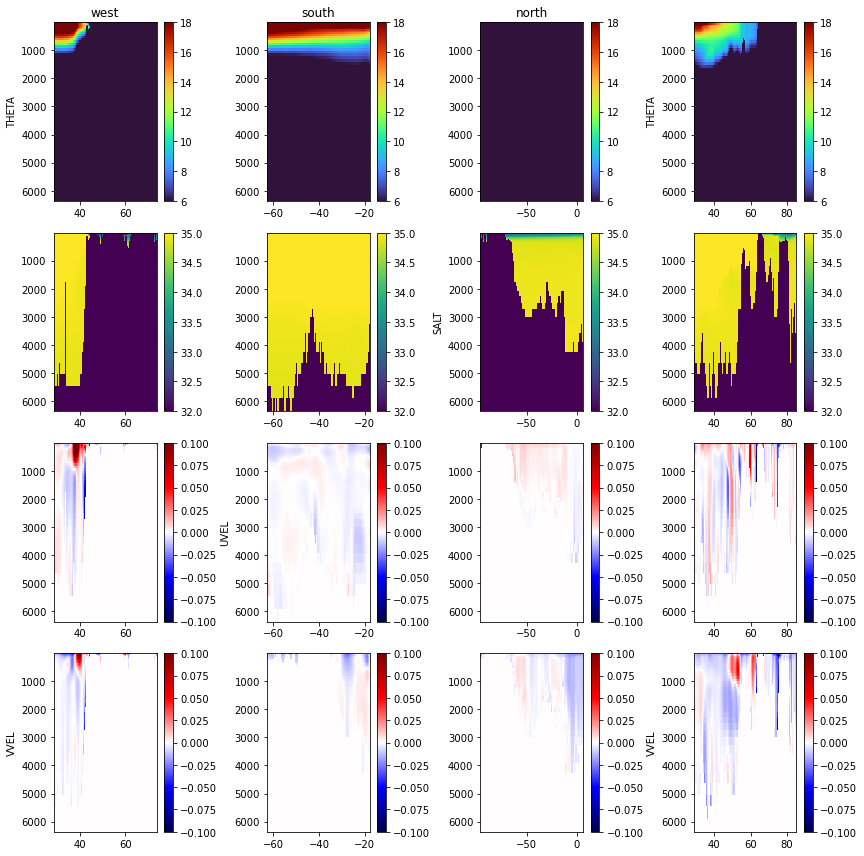

In [14]:
fig = plt.figure(figsize=(12,12))
plot_year = 1992
Z = np.cumsum(delR)
plot_counter = 0
for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    for boundary in boundary_list:
        
        boundary_grid = np.fromfile(os.path.join(input_dir,'obcs',variable_name+'_'+boundary+'_'+str(plot_year)),'>f4')
    
        if boundary in ['west','east']:
            boundary_grid = boundary_grid.reshape((timesteps, np.shape(delR)[0],np.shape(XC)[0]))
            boundary_grid = boundary_grid[0, :, :] # choose just the first timestep for plotting
            if boundary=='west':
                x = YC[:,1]
            if boundary=='east':
                x = YC[:,-1]
        else:
            boundary_grid = boundary_grid.reshape((timesteps, np.shape(delR)[0],np.shape(XC)[1]))
            boundary_grid = boundary_grid[0, :, :] # choose just the first timestep for plotting
            if boundary=='north':
                x = XC[-1,:]
            if boundary=='south':
                x = XC[1,:]

        plot_counter += 1
        plt.subplot(len(variable_names),len(boundary_list),plot_counter)
        C = plt.pcolormesh(x, Z, boundary_grid,
                           vmin=meta_dict[variable_names[i]][0],
                           vmax=meta_dict[variable_names[i]][1],
                           cmap=meta_dict[variable_names[i]][2])
        plt.colorbar(C,fraction=0.26)
        plt.gca().invert_yaxis()
    
        if plot_counter%3==1:
            plt.ylabel(variable_name)
        if plot_counter<4:
            plt.title(boundary)

plt.tight_layout()

plt.show()

Looks good! Now, with the initial conditions, external forcing conditions, and boundary conditions we are nearly ready to start testing the model!

### An additional field for 1991
When the model is initiated in 1992, the regional model will interpolate between times to compute the boundary conditions. However, this will require one timestep from the end of 1991 - which we don't have. To initiate the model, we can copy over the boundary conditions from the start of 1992 to the end of 1991 for consistency.

In [15]:
for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    for boundary in boundary_list:
        print('Copying '+variable_name+' 1992 conditions for the '+boundary+' boundary in 1991')

        boundary_grid = np.fromfile(os.path.join(input_dir,'obcs',variable_name+'_'+boundary+'_1992'),'>f4')
    
        if boundary in ['west','east']:
            boundary_grid = boundary_grid.reshape((timesteps, np.shape(delR)[0],np.shape(XC)[0]))
        else:
            boundary_grid = boundary_grid.reshape((timesteps, np.shape(delR)[0],np.shape(XC)[1]))

        boundary_grid_1991 = np.copy(boundary_grid)
        for timestep in range(12):
            boundary_grid_1991[timestep,:,:] = boundary_grid[0,:,:]

        output_file = os.path.join(input_dir,'obcs',variable_name+'_'+boundary+'_'+str(1991))
        boundary_grid_1991.ravel('C').astype('>f4').tofile(output_file)


Copying THETA 1992 conditions for the west boundary in 1991
Copying THETA 1992 conditions for the south boundary in 1991
Copying THETA 1992 conditions for the north boundary in 1991
Copying THETA 1992 conditions for the east boundary in 1991
Copying SALT 1992 conditions for the west boundary in 1991
Copying SALT 1992 conditions for the south boundary in 1991
Copying SALT 1992 conditions for the north boundary in 1991
Copying SALT 1992 conditions for the east boundary in 1991
Copying UVEL 1992 conditions for the west boundary in 1991
Copying UVEL 1992 conditions for the south boundary in 1991
Copying UVEL 1992 conditions for the north boundary in 1991
Copying UVEL 1992 conditions for the east boundary in 1991
Copying VVEL 1992 conditions for the west boundary in 1991
Copying VVEL 1992 conditions for the south boundary in 1991
Copying VVEL 1992 conditions for the north boundary in 1991
Copying VVEL 1992 conditions for the east boundary in 1991
